分布式Q-learning：对Q-learning进行扩展，使其不仅要确定动作-价值的点估计，还要确定每个动作的动作-价值的完整分布。

普通Q函数接收一个状态-动作对并计算相关的Q值。分布式Q函数接收一个状态-动作对并计算所有可能Q值的概率分布，概率范围为[0,1]，因此他会返回一个向量，其中所有元素的值都在[0,1]内，并且所有元素的总和为1。

频率论：

1、概率是个体结果的频率

2、计算给定模型下数据的概率

3、使用假设检验

4、计算简单

贝叶斯论：

1、概率是信赖的程度

2、计算给定数据下模型的概率

3、使用参数估计或模型比较

4、（通常）计算困难

概率分布的支集：非零概率的结果的子集

先验概率分布：在接收新信息之前最初的分布

后验概率分布：在接收新信息之后的分布

先验概率分布和后验概率分布的区别是有关联的，因为在接收到另一组新信息之前，后验概率分布会变成下一次迭代的先验概率分布。

贝叶斯推理过程：从一个先验概率分布开始，接收一些新信息，然后利用这些新信息将先验概率分布更新成一个新的、信息更丰富的后验概率分布。

In [3]:
import numpy as np
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


 期望值可以用 prob 数组和 outcomes 数组之间的内（点）积来计算，因为内积会进行相同的操作，即将两个数组中每个对应元素相乘，然后求和。

In [4]:
expected_value = probs @ outcomes
print(expected_value)

18.400000000000002


离散概率分布意味着他的样本空间是一个有限的集合，即他的样本空间只会出现有限数量的可能结果。

离散分布类似于结果值 numpy 数组相关联的概率 numpy 数组，其概率和结果都是有限的。

连续分布表示无限多个的可能结果，纵轴表示概率密度（表示结果在一个小区间内取值的概率）

此处我们将T 设置为一个匿名函数，他不接收任何参数，每次调用他时就会在 18.4 上加上一个小的随机数。T 的方差是 1，意味着T 返回的大多数值将在 18.4-1 到 18.4+1 的范围内。

In [5]:
t0 = 18.4
#一个匿名函数，不需要使用 def 关键字定义，这个函数没有参数（冒号前面为空）
#函数体是t0 + np.random.randn(1)
T = lambda: t0 + np.random.randn(1)
T()

array([18.19959621])

<BarContainer object of 51 artists>

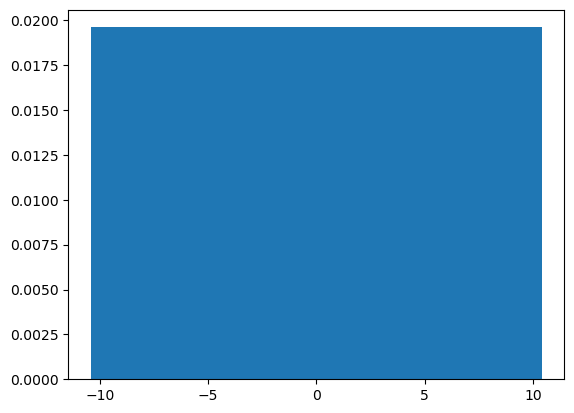

In [6]:
import torch
import numpy as np
from matplotlib import pyplot as plt

vmin,vmax = -10.,10. #设置分布支集的最小值和最大值
nsup=51 #设置支集的元素数量（采样点数量）
#np.linspace：创建一个等间隔的数组（起始值，结束值，样本数量）
support = np.linspace(vmin,vmax,nsup) #创建支集张量，一个元素为-10到+10等间隔值的张量
probs = np.ones(nsup)  #创建一个长度为 nsup 的全 1 数组
probs /= probs.sum()  #将数组归一化，使所有元素之和为 1
z3 = torch.from_numpy(probs).float()   #将NumPy数组转换为PyTorch浮点张量
plt.bar(support,probs) #绘制分布的柱状图

以上定义了一个均匀分布，现在定义一个更新分布，用函数update_dist(z,reward)使他接收一个先验概率分布和一个观察奖励，并返回一个后验概率分布。

In [7]:
support

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

更新概率分布

In [8]:
"""
r:当前获得的奖励值
probs:当前的概率分布
lim:分布支集的范围
gamma:折扣因子。用于权衡未来奖励的重要性
"""
def update_dist(r,probs,lim=(-10.,10.),gamma=0.8):
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #计算支集间距
    #np.round：四舍五入
    #np.clip：确保索引在有效范围内（0 到 nsup-1）
    bj = np.round((r-vmin)/dz) #计算观察奖励在支集中的索引
    bj = int(np.clip(bj,0,nsup-1)) #取整和截取值以确保他是一个有效的支集索引
    m = probs.clone()  #创建当前概率分布的副本，以便进行更新操作
    j = 1
    for i in range(bj,1,-1): #从左近邻开始，窃取其部分概率质量
        #np.power(gamma, j)：gamma 的 j 次幂，即衰减因子
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #从右近邻开始，窃取其部分概率质量
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #除以总和，以确保其总和为 1
    return m

In [9]:
probs

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

在观察一次之后重新分配概率质量

观察到单个奖励后更新初始均匀分布到结果。一些概率质量被重新分配到与观察奖励对应的支集元素上。

<BarContainer object of 51 artists>

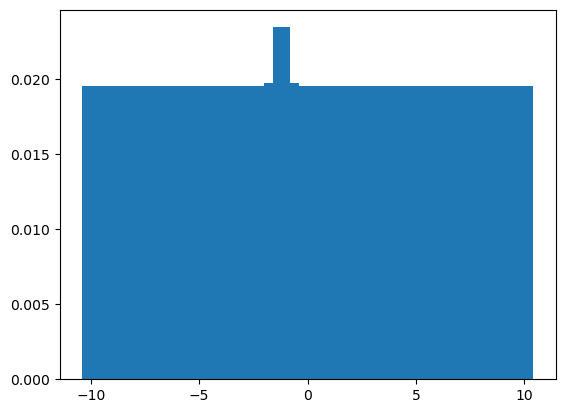

In [10]:
ob_reward = -1
#转换为PyTorch浮点张量。
Z = torch.from_numpy(probs).float()
# 修正函数调用，只传入必要的位置参数，其他用关键字参数
Z = update_dist(ob_reward, Z, lim=(vmin,vmax), gamma=0.1)
plt.bar(support,Z)

利用一系列观察值重新分配概率质量

从下面代码运行图可以看出，有 4 个不同峰值，分别对应 4 个不同类型的观察奖励，即 10、1、0、和-10.最高的峰值（分布模态）对应于 10，因为他是频率最高的观察奖励。

图：观察一系列不同奖励后更新初始均匀分布的结果，其中分布中的每个峰对应于一个观察奖励。

<BarContainer object of 51 artists>

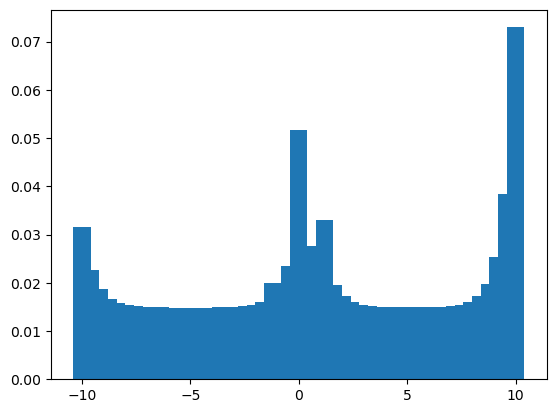

In [11]:
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], Z, lim=(vmin,vmax), gamma=0.5)
plt.bar(support, Z)

利用一系列相同的奖励来减小方差

从下代码运行图中可以看到，均匀分布转变成一个以 5 为中心的、方差更小的拟正态分布。

图：多次观察相同的奖励后更新初始均匀概率分布的结果。最终，均匀分布趋于一个拟正态分布

<BarContainer object of 51 artists>

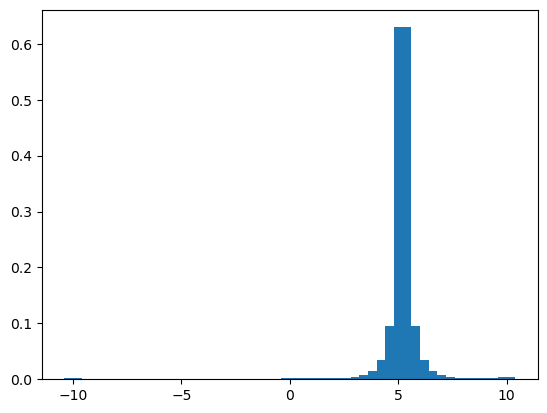

In [12]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], Z, lim=(vmin,vmax), gamma=0.7)
plt.bar(support, Z)

实现Dist-DQN 的函数


在本代码中，手动进行梯度下降操作。用Dist-DQN 接收一个名为 theta 的参数向量，并将该向量拆包并重塑成大小合适的多个单独的矩阵层。这可以让梯度下降操作变得更加容易，因为我们可以在单个向量上而非多个独立的实体上进行梯度下降。还将使用一个单独的目标网络，为此需要保留一个 theta 的副本，并将其传递到相同的 dist-dqn 函数。

另一个新颖之处是多个输出‘头’。我们习惯让一个神经网络返回一个输出向量，但在这种情况下，我们希望他返回一个矩阵。为此我们设置了一个循环，让三个独立的层矩阵分别乘 12，从而产生 3 个不同的输出向量，然后将他们堆叠成一个矩阵。除此之外，他是一个共包含 5 个密集层的非常简单的神经网络。

In [13]:
def dist_dqn(x,theta,aspace=3): #x 是有128 个元素的状态向量，theta 是参数向量，aspace 是动作空间的大小。
    #输入维度、第一个隐藏层维度、第二个隐藏层维度、值分布的支集大小
    dim0,dim1,dim2,dim3 = 128,100,25,51 #定义层的维度，以便将theta分解层大小合适的矩阵
    #t1：第一个隐藏层参数的数量
    t1 = dim0*dim1
    #t2：第二个隐藏层参数的数量
    t2 = dim2*dim1
    #theta1：从theta中提取前t1个元素，并将其重塑为形状为(dim0, dim1)的矩阵，作为输入层到第一个隐藏层的权重矩阵
    theta1 = theta[0:t1].reshape(dim0,dim1) #将theta的第一部分解压到第一层矩阵中
    #theta2：从theta中提取从t1到t1+t2个元素，并将其重塑为形状为(dim1,dim2)的矩阵，作为第一个隐藏层到第二个隐藏层的权重矩阵
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    l1 = x @ theta1 #该计算的维度为B*128*128*100=B*100，其中B是批量大小 
    l1 = torch.selu(l1)
    l2 = l1 @ theta2  #该计算的维度为B*100*100*25=B*25
    l2 = torch.selu(l2)
    l3 = []  #初始化一个空列表，用于存储每个动作的价值分布
    for i in range(aspace): #循环遍历每个动作来生成每个动作-价值分布
        step = dim2*dim3
        #t1+t2：这部分表示前两个隐藏层（输入层到第一个隐藏层、第一个隐藏层到第二个隐藏层）参数的总数量。所以t1+t2就是第二个隐藏层之后参数的起始索引
        theta5_dim = t1 + t2 + i * step  #从 theta 中提取当前动作对应的参数的起始位置。
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 #该计算的维度为B*25*25*51=B*51
        l3.append(l3_)
    #torch.stack 函数用于在指定维度上对一系列张量进行堆叠操作，将多个相同形状的张量合并成一个更高维度的张量
    l3 = torch.stack(l3,dim=1) #最后一层的维度为B*51*3=B*153，其中B是批量大小
    l3 = torch.nn.functional.softmax(l3,dim=2)  #指定在第 2 个维度（从 0 开始计数）上应用 softmax 函数
    return l3.squeeze()

计算目标分布

现在我们需要一个函数用于接收Dist-DQN 的输出、一个奖励和一个动作，并生成我们希望神经网络接近的目标分布。这个函数将用到update_dist 函数，但他只想更新与实际执行的动作关联的分布。当达到终止状态时，我们还需要一个不同的目标。在终止状态下，期望的奖励就是观察到的奖励，因为根据定义，此时不存在未来奖励。这意味着贝尔曼更新会减小到$Z(s_{t},a_{t})<-R(s_{t},A_{t})$。由于只观察到一个奖励，且没有先验概率分布去更新，因此目标分布就变成了所谓的退化分布。他只是一种特别的分布，其中所有的质量集中在单个值上

get_target_dist 函数接收一批维度为B*3*51 的数据（B 是批大小），并返回一个尺寸相等的张量。

In [14]:
"""
dist_batch:当前状态-动作对的值分布批次
action_batch:执行的动作批次
reward_batch:获得的奖励批次
support:分布支集
lim:分布支集范围
gamma:折扣因子
"""
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #遍历批次维度
        dist_full = dist_batch[i] #当前批次样本的所有动作的值分布，形状为 (num_actions, num_support)
        #item()是PyTorch张量的一个方法，把只包含一个元素的张量转换为Python的标量值
        action = int(action_batch[i].item())    
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #如果奖励不是-1，它就是一个终止状态，此时目标分布是一个奖励值上的退化分布
            target_dist = torch.zeros(nsup)
            #np.round：四舍五入
            #np.clip：确保索引在有效范围内（0 到 nsup-1）
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.  #将目标分布的第 bj 个元素设为 1，表示目标分布是一个在奖励值上的退化分布。
        else: #如果是非终止状态，则目标分布是给定奖励上的先验分布的贝叶斯更新
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #只改变所采取动作的分布
        
    return target_dist_batch

训练生成模型（生成数据的模型）的方式：通过概率性的思考，可以将神经网络想象为生成合成数据并试图训练神经网络产生更多现实的数据-一些与经验数据集非常相似的数据。

交叉熵损失函数

以下代码将交叉熵损失实现为一个函数，用于接收一批动作-价值分布，并预测分布与目标分布之间的损失

lossfn 函数接收一个维度为B✖️3✖️51 的预测分布 x 和一个相同维度的目标分布 y。然后沿着动作维度将分布扁平化，从而得到B✖️153 的矩阵；接着遍历矩阵中每个 1✖️153 的行并计算 1✖️153 预测分布和 1✖️153 目标分布之间的交叉熵损失。我们不用显式的对x 和 y 的乘积求和，而是可以结合这两个操作通过使用内积操作符@一次性得到结果。

我们可以选择只计算所采取动作的特定动作-价值分布之间的损失，但最终计算了所有这 3 个动作-价值的损失，以便Dist-DQN 学习保持其他两个未采取的动作不变，而只更新所采取动作的动作-价值分布。

In [15]:
def lossfn(x,y):#预测分布x与目标分布y的交叉熵损失
    loss = torch.Tensor([0.]) #创建初始损失值为0的张量
    loss.requires_grad=True  #使其能够计算梯度，用于后续的反向传播
    for i in range(x.shape[0]): #遍历批次维度 
        #沿着动作维度进行扁平化处理，以得到一个串联的分布序列
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) 
        loss = loss + loss_
    return loss

使用模拟数据进行测试

下面使用模拟目的目标分布来测试目前为止的所有部分，以查看Dist-DQN 是否能够成功的学习匹配目标分布。我们采用一个初始的均匀分布，将其通过Dist-DQN运行，并使用两个奖励观察值的合成向量来更新他

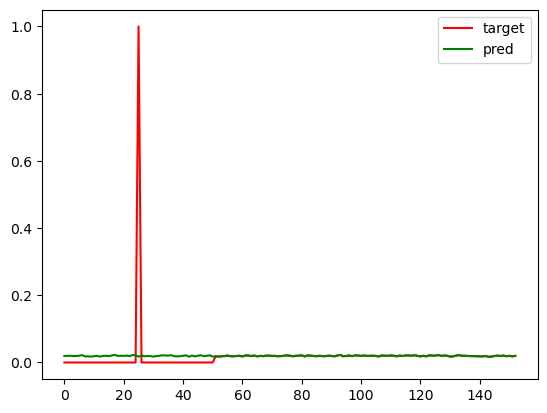

In [16]:
aspace = 3 #定义空间大小为 3
#第一层参数：128×100 第二层参数：25×100 输出层参数：3×25×51（每个动作一个分布）
tot_params = 128*100 + 25*100 + aspace*25*51 #根据层大小定义Dist-DQN 参数的总数
#将每个元素都除以10是对生成的随机数张量进行缩放操作，目的是为了把初始化的参数值控制在一个较小的范围内，避免参数值过大或者过小
theta = torch.randn(tot_params)/10. #为Dist-DQN随机初始化一个参数向量
theta.requires_grad=True
theta_2 = theta.detach().clone() #复制theta 作为一个目标网络

vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75 #每75步同步主模型的参数和目标Dist-DQN 参数
support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10. #为测试随机初始化两个状态
action_batch = torch.Tensor([0,2]) #创建合成动作数据
reward_batch = torch.Tensor([0,10]) #创建合成奖励数据
losses = [] 
pred_batch = dist_dqn(state,theta,aspace=aspace) #初始化一个预测批次
target_dist = get_target_dist(pred_batch,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #初始化一个目标批次

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.legend()

以上代码的目的是测试Dist-DQN 对两个合成数据样本的分布的学习能力。在合成数据中，动作 0 和奖励 0 相关，而动作 2 与奖励 10 相关。我们期望Dist-DQN 学习到状态 1 与动作 1 关联，状态 2 与动作 2 关联，并学习其分布。在上述代码运行图中可以看出利用随机初始化的参数向量，所有这 3 个动作的预测分布（我们沿着动作维度进行了扁平化处理）几乎是均匀分布，而目标分布在无操作动作处有一个峰值。训练之后，预测分布和目标分布应该比较匹配。

 目标网络之所以如此重要，是因为在Dist-DQN 中体现的非常清楚。目标网络仅仅是滞后一段时间更新的主模型的副本。我们使用目标网络的预测来创建学习的目标，但仅使用主模型的参数来实现梯度下降，这样可以稳定训练，因为在没有目标网络的情况下，每个参数从梯度下降更新后目标分布都会发生变化。

然而，梯度下降试图将参数朝着更好匹配目标分布的方向移动，因此存在一个循环（因此不稳定），可能会因为Dist-DQN 的预测与目标分布之间的跳跃导致目标分布发生显著变化。使用Dist-DQN 预测的一个滞后副本（通过参数的滞后副本，即目标网络），目标分布不会在每次迭代时发生变化，也不会立即受到主Dist-DQN 模型的持续更新的影响，这就大大稳定了训练。如果将update-rate 降到 1 并尝试训练，你将看到目标变得完全错误。

以上代码运行图：观察一个奖励后未经训练的Dist-DQN 产生的预期动作-价值分布和目标分布。有 3 个独立的包含 51 个元素的动作-价值分布，但此处他们被连接成一个长向量来说明预测和目标之间的整体匹配程度。前 51 个元素对应无操作动作的动作-价值分布，中间 51 个元素对应向上动作的动作-价值分布，最后 51 个元素对应向下动作的动作-价值分布。可以看见这 3 个动作的预测都是完全平坦（均匀）的分布，而目标分布对无操作动作有一个模态（峰值），对其他两个动作有一些噪声峰值。目标是让预测匹配目标分布。

## Dist-DQN 在合成数据上的训练

以上代码的运行图显示了训练后目标和Dist-DQN 预测几乎完全匹配（甚至可能看不出有两个重叠的分布）。模型起作用了。以下代码运行的损失图表明每次目标网络同步到主模型以及目标分布突然变化时都会出现峰值，导致该时间步上的损失高于正常情况。

以下代码运行图：随训练时间变化的损失图。基线损失正在减小，但可以看到不断增大的峰值

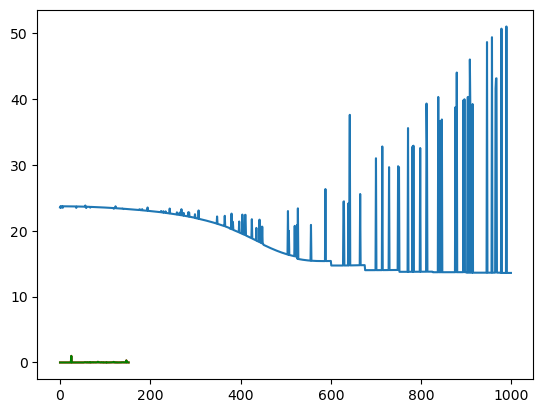

In [17]:
for i in range(1000):
    #创建基础奖励张量+添加高斯噪声（均值为 0，标准差为 0.1），防止模型过拟合
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #添加一些随机噪声到奖励中，以减小过拟合
    pred_batch = dist_dqn(state,theta,aspace=aspace) #使用主模型Dist-DQN 进行分布预测
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace) #用目标网络Dist-DQN 进行分布预测（使用滞后参数）
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #用目标网络的分布来创建学习的目标分布
    #计算主模型预测与目标分布之间的损失，并反向传播梯度。
    #target_dist.detach()：阻止目标分布的梯度传播（目标网络参数不更新）
    loss = lossfn(pred_batch,target_dist.detach()) #在损失函数中使用主模型的分布预测
    losses.append(loss.item())
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    #每隔 update_rate 次迭代，将目标网络参数 theta_2 更新为主模型参数 theta
    if i % update_rate == 0: #将目标网络参数与主模型参数同步
        theta_2 = theta.detach().clone()

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.plot(losses)

### 可视化学习到的动作-价值分布

从运行图中可以看到，在第一个样本中，左侧动作 0 相关的分布已经变为一个 0 处的退化分布，就像模拟数据一样。然而，其他两个动作的分布仍然相当平均，没有明确的峰值。同样，在批次的第二个样本中，动作 2（向下）的分布是一个接近于 10处的退化分布，因为数据也退化了（一组相同的样本），而其他两个动作的分布仍然相当平均。

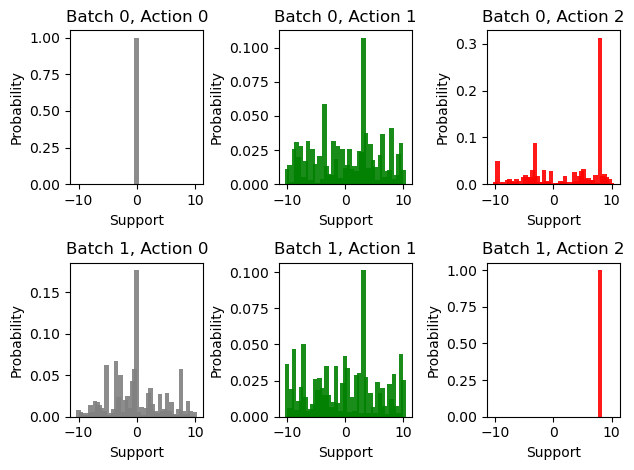

In [18]:
tpred = pred_batch #获取预测分布
cs = ['gray','green','red'] #为三个动作设置不同的颜色
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)

for j in range(num_batch): #遍历批次中的经验
    for i in range(tpred.shape[1]): #遍历每个动作
        #bar()：绘制条形图，横轴为支持点，纵轴为预测分布值
        ax[j,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}'.format(i),alpha=0.9,color=cs[i])
        ax[j, i].set_title(f"Batch {j}, Action {i}")
        ax[j, i].set_xlabel("Support")
        ax[j, i].set_ylabel("Probability")

plt.tight_layout()
plt.show()

### 预处理状态和选择动作

用一个简单的策略基于动作的期望值选择动作，以便将复杂性降到最低。虽然我们在学习一个完整的概率分布，但是将基于动作的期望值来选择动作，就像在普通的Q-learning 中一样。

In [19]:
#该函数的主要作用是对输入的状态进行预处理，将其转换为PyTorch张量，添加一个批次维度，并对状态值进行归一化处理。
def preproc_state(state):
    #unsqueeze函数用于在指定维度上增加一个维度。dim=0表示在第0维（批次维度）上添加一个维度。
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1) #将状态值归一化到 0～1
    return p_state
    
#该函数的主要作用是根据输入的值分布 dist 和分布支集 support 来选择动作
def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): #遍历分布的批次维度
        #dist[b, a, :] 是第 b 个批次样本中第 a 个动作的值分布
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #计算点积，得到每个动作-价值分布的期望值
        action = int(np.argmax(expectations)) #计算最高期望值关联的动作
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [1]:
import gymnasium as gym
from collections import deque
env = gym.make('ALE/Freeway-ram-v5')
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

#Initialize DQN parameter vector
tot_params = 128*100 + 25*100 + aspace*25*51  #H 
theta = torch.randn(tot_params)/10. #I 
theta.requires_grad=True
theta_2 = theta.detach().clone() #J 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset()[0])

NamespaceNotFound: Namespace ALE not found. Have you installed the proper package for ALE?

Dist-DQN 的方式的一个重要限制，即使用的是具有有限支集的离散概率分布，因此只能表示-10～10（很小范围内）的动作-价值。我们可以用更多的计算处理代价来扩大这个范围，但是无法通过这种方式表示任意大小的值。我们的实现方式是使用一个固定大小的支集来学习所关联的概率集合。

解决这个问题的一种方法是在一个变化的（学习到的）支集集合是使用一组固定的概率。我们可以将概率张量固定在 0.1~0.9，并让Dist-DQN 预测与这些固定概率关联的支集集合。也就是说，我们让Dist-DQN 学习什么支集值具有概率0.1,0.2....这被称为分位数回归，因为这些固定概率最终代表了分布的分位数。

在分位数回归中，我们不学习分配给一组固定支集的概率，而是学习一组对应于一组固定概率（分位数）的支集。

小结：

分布式Q-learning 的优势包括改进的性能以及提供了一种使用风险敏感策略的方式

优先回放可以通过在经验回放缓冲器中提供信息丰富的经验的比例来加速学习

OpenAI Gym 包含可以产生RAM 状态（而非原始视频帧）的替代环境。RAM 状态更容易学习，因为他们的维度通常要低的多

随机变量是一种可以接收一组由潜在概率分布加权的结果的变量

概率分布的熵描述了他包含多少信息

KL 散度和交叉熵可用来衡量两个概率分布之间的损失

概率分布的支集是一组具有非 0 概率的值

分位数回归是一种通过学习支集集合（而非概率集合）来学习高度灵活的离散分布的方法